In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

<IPython.core.display.Javascript object>


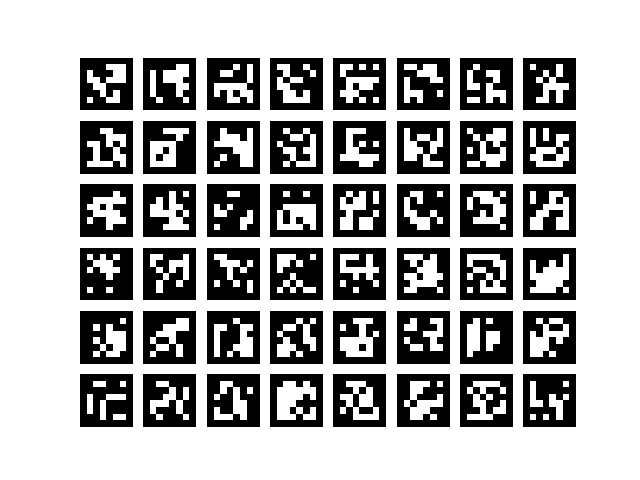

In [2]:
imagesFolder = "E:\Desktop\S8\Projet 851\data"

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i-1, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig(imagesFolder + "/markers.pdf")    
plt.show()
#plt.close()

<IPython.core.display.Javascript object>


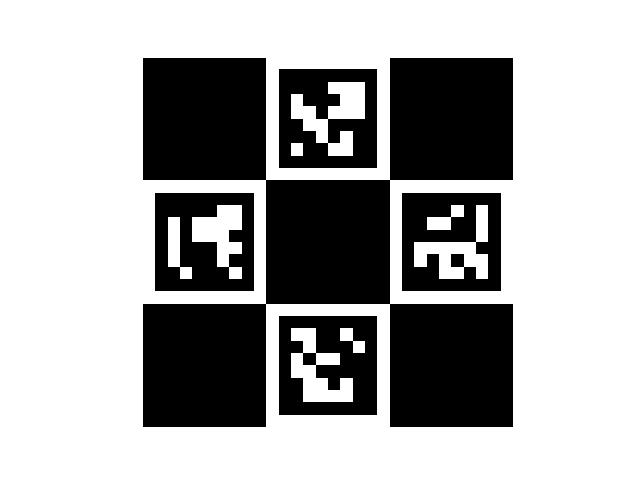

Imprimer le damier de calibration!


In [22]:
board = aruco.CharucoBoard_create(3, 3, 1, 0.8, aruco_dict)
imboard = board.draw((4000, 4000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
cv2.imwrite(imagesFolder + "/chessboard.tiff",imboard)
#plt.savefig(imagesFolder + "/chessboard.pdf")   
plt.grid()
plt.show()
print("Imprimer le damier de calibration!")

In [6]:
import cv2
import math

videoFile = "E:/Desktop/S8/Projet 851/outpy.avi"
imagesFolder = "E:/Desktop/S8/Projet 851/data/"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId <150):
        filename = imagesFolder + "\image_" +  str(int(frameId)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


<IPython.core.display.Javascript object>


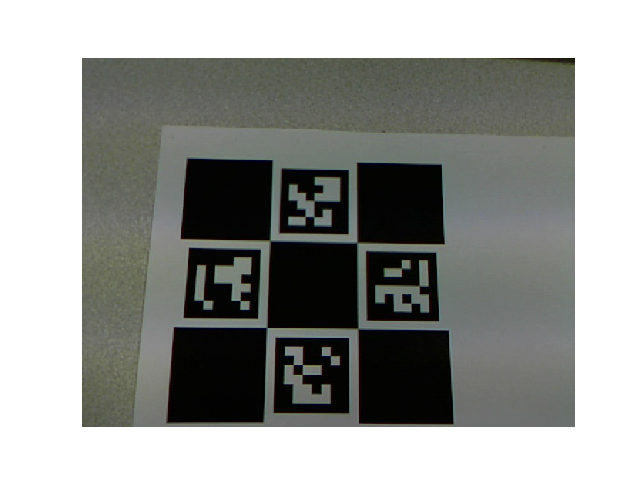

In [7]:
im = PIL.Image.open(imagesFolder + "\image_0.jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
ax.axis('off')
plt.show()

In [9]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    
    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              

        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize
    print("finished")

In [10]:
#%%time
images = [imagesFolder + f for f in os.listdir(imagesFolder) if f.startswith("image_")]
allCorners,allIds,imsize=read_chessboards(images)



POSE ESTIMATION STARTS:
=> Processing image E:/Desktop/S8/Projet 851/data/image_69.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_139.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_15.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_145.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_12.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_142.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_60.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_130.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_67.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_137.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_52.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_2.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_83.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_102.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_29.jpg
=> Processing image E:/Des

=> Processing image E:/Desktop/S8/Projet 851/data/image_134.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_18.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_148.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_63.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_133.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_6.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_56.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_87.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_106.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_51.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_1.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_80.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_101.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_23.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/image_24.jpg
=> Processing image E:/Desktop/S8/Projet 851/data/im

In [11]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors
    print("finished")

In [12]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
ret

CAMERA CALIBRATION
Wall time: 12min 46s


In [13]:
mtx


array([[  1.46963466e+03,   0.00000000e+00,   2.63094117e+02],
       [  0.00000000e+00,   1.47297770e+03,   3.19127464e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [17]:
dist

array([[ -4.15557150e+00],
       [  8.04563425e+02],
       [  1.72644822e-01],
       [ -4.62914356e-02],
       [ -1.41439828e+04],
       [  4.99936408e+00],
       [ -2.89968864e+02],
       [  1.96691829e+04],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00]])

In [15]:
np.savetxt(imagesFolder+"calib_mtx_webcam.csv", mtx)
np.savetxt(imagesFolder+"calib_dist_webcam.csv", dist)

## Check calibration 

<IPython.core.display.Javascript object>


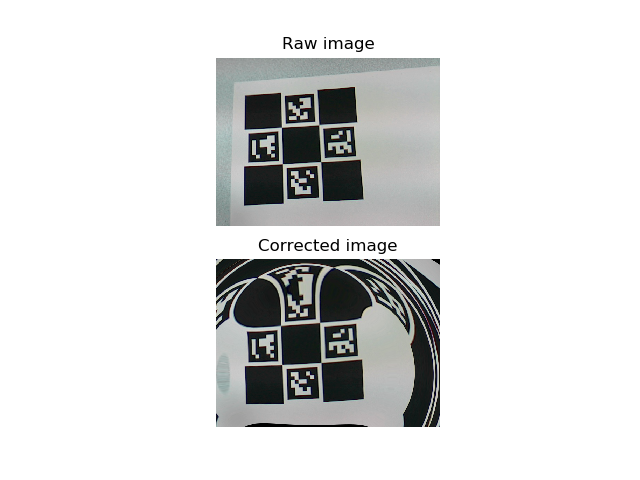

In [18]:
i=24 # select image id
plt.figure()
frame = cv2.imread(imagesFolder + "image_100.jpg".format(i))
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(211)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(212)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

# Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


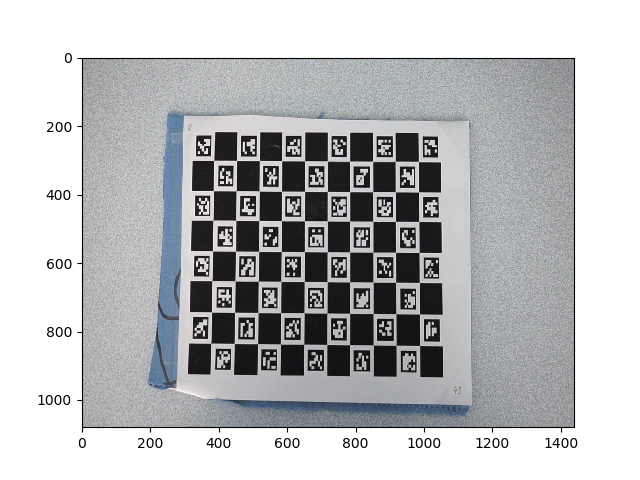

In [45]:
frame = cv2.imread(imagesFolder + "image_10.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

# Post processing

In [46]:
%%time

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

Wall time: 38.1 ms


# Result

<IPython.core.display.Javascript object>


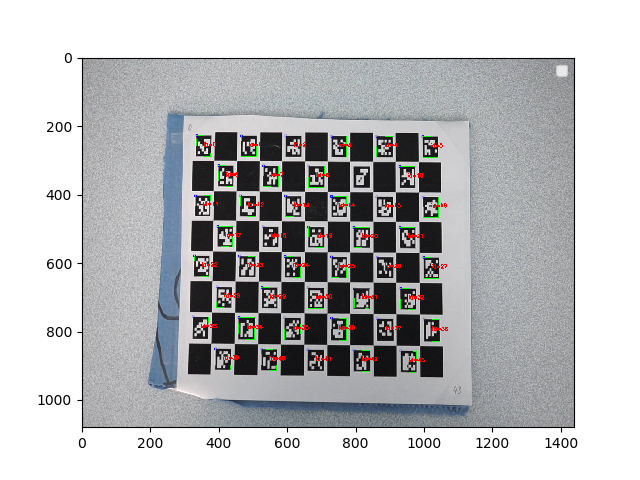

No handles with labels found to put in legend.


In [47]:
conn = np.array([0, 1, 2, 3, 0])
plt.figure()
plt.imshow(frame_markers)
plt.legend()
plt.show()

### Add local axis on each maker

In [48]:
size_of_marker =  0.0145 # side lenght of the marker in meter
rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [49]:
tvecs

array([[[ 0.03625717,  0.04684617,  0.46653871]],

       [[ 0.07796683,  0.00174052,  0.44514342]],

       [[ 0.0131153 , -0.02022943,  0.44694283]],

       [[-0.11509333, -0.02061886,  0.4465331 ]],

       [[ 0.07544442, -0.0398416 ,  0.43262915]],

       [[ 0.09802467, -0.06131984,  0.44035666]],

       [[ 0.05448294, -0.06054667,  0.4326234 ]],

       [[ 0.05369867,  0.0631415 ,  0.42116605]],

       [[-0.11193155,  0.06244439,  0.427018  ]],

       [[ 0.05551877,  0.02247846,  0.43705436]],

       [[ 0.05492523, -0.01945728,  0.43442988]],

       [[-0.00789508, -0.03981689,  0.42867534]],

       [[-0.07027212, -0.06136102,  0.43652852]],

       [[ 0.07773333,  0.08803092,  0.43954609]],

       [[ 0.03309225,  0.08473541,  0.42561175]],

       [[-0.0083905 ,  0.08445285,  0.42618681]],

       [[-0.05225633,  0.08741113,  0.4432211 ]],

       [[-0.09553183,  0.08714634,  0.44444085]],

       [[ 0.09551237,  0.06367101,  0.42236155]],

       [[ 0.01270016,  0.065401

In [50]:
tvecs.shape

(43, 1, 3)

In [51]:
np.degrees(rvecs)

array([[[  1.62516394e+02,   2.46355609e+00,  -1.09402896e+01]],

       [[  1.79457420e+02,   7.19277484e-02,  -1.32140582e+00]],

       [[  1.77773147e+02,  -9.91113450e-01,   5.53146653e+00]],

       [[ -1.85403347e+02,  -2.23002873e-01,   1.24063729e+01]],

       [[  1.81444729e+02,  -7.25485937e-01,   1.04275177e+01]],

       [[  1.77398449e+02,  -2.71016859e-01,   7.89579400e+00]],

       [[  1.73242093e+02,   1.79338050e+00,  -5.06408000e+00]],

       [[  1.66617310e+02,  -7.61331890e-01,  -1.96025399e+01]],

       [[ -1.79129608e+02,  -4.21227613e+00,  -6.45245428e+01]],

       [[  1.81282644e+02,  -1.57056435e-01,  -6.86839568e-01]],

       [[  1.65840660e+02,   9.53216792e-01,  -4.33656312e+00]],

       [[  1.76040502e+02,   1.50523348e+00,  -1.30437940e+01]],

       [[  1.72773893e+02,   9.89154542e-01,  -6.18063691e+00]],

       [[ -1.83491628e+02,  -2.23552817e+00,  -8.18637179e-01]],

       [[ -1.76798040e+02,  -1.43834284e+00,   2.15416822e-01]],

       [[ 

In [52]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


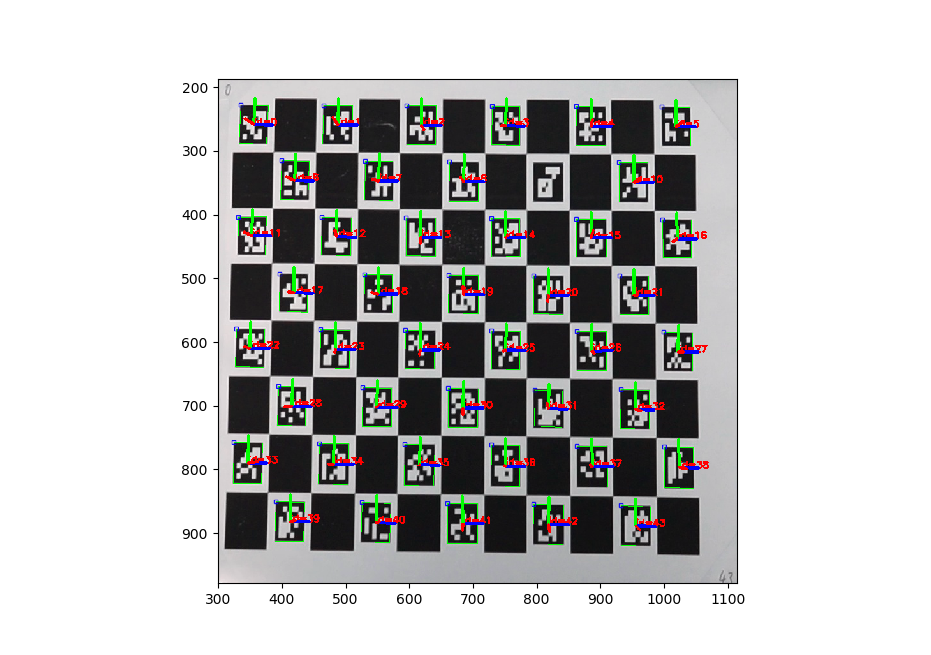

In [53]:
plt.figure()
plt.imshow(imaxis)
plt.show()

In [54]:
data=pd.DataFrame(data=tvecs.reshape(43,3),columns=["tx","ty","tz"],index=ids.flatten())
data.index.name="makers"
data.sort_index(inplace=True)
data

,tx,ty,tz
makers,,,
0,-0.112976,-0.062107,0.442287
1,-0.070272,-0.061361,0.436529
2,-0.029102,-0.061471,0.437813
3,0.013126,-0.062967,0.449129
4,0.054483,-0.060547,0.432623
5,0.098025,-0.061320,0.440357
6,-0.091830,-0.040953,0.438378
7,-0.050168,-0.040780,0.437449
8,-0.007895,-0.039817,0.428675


In [55]:
p=data.values
((p[1]-p[0])**2.).sum()**.5,((p[2]-p[1])**2.).sum()**.5,((p[3]-p[2])**2.).sum()**.5

(0.04309652659780655, 0.041190101023714003, 0.043743470242086288)

In [56]:
((data.loc[11]-data.loc[0]).values**2).sum()

0.001743801337263979

In [57]:
V0_1= p[1]-p[0]
V0_11=p[11]-p[0]
V0_1,V0_11

(array([ 0.0427035 ,  0.00074629, -0.00575889]),
 array([ 0.04097137,  0.04177   ,  0.00013852]))

In [58]:
np.dot(V0_1,V0_11)

0.0017799953347752665

<IPython.core.display.Javascript object>


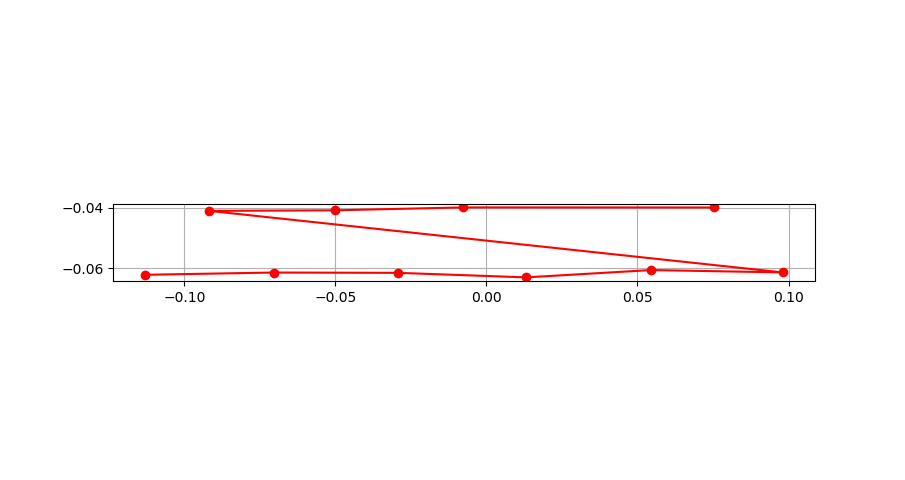

In [59]:
fig=plt.figure()
ax= fig.add_subplot(1,1,1)
ax.set_aspect("equal")
plt.plot(data.tx[:10], data.ty[:10],"or-")
plt.grid()
plt.show()

In [ ]:
data.tx

In [60]:
corners=np.array(corners)
data2=pd.DataFrame({"px":corners[:,0,0,1],"py":corners[:,0,0,0]},index=ids.flatten())
data2.sort_index(inplace=True)

data2

,px,py
0,229.0,335.0
1,230.0,465.0
2,230.0,595.0
3,231.0,729.0
4,231.0,861.0
5,232.0,995.0
6,316.0,399.0
7,317.0,530.0
8,318.0,662.0
10,319.0,928.0


In [61]:
n0=data2.loc[0]
n1=data2.loc[1]
d01=((n0-n1).values**2).sum()**.5
d=42.5e-3
factor=d/d01
data2["x"]=data2.px*factor
data2["y"]=data2.py*factor
d1_0=data2.loc[2].y-data2.loc[1].y
d11_0=data2.loc[11].x-data2.loc[0].x
d1_0


0.042498738

In [62]:
d11_0

0.057536766

In [19]:
imagesFolder = "E:\Desktop\S8\Projet 851\data"
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.CharucoBoard_create(3,3,.025,.0125,dictionary)
img = board.draw((200*3,200*3))
cv2.imwrite(imagesFolder + '\charucotest.png',img)


True

In [8]:
help (aruco)

Help on module cv2.aruco in cv2:

NAME
    cv2.aruco

FUNCTIONS
    Board_create(...)
        Board_create(objPoints, dictionary, ids) -> retval
        .   * @brief Provide way to create Board by passing nessesary data. Specially needed in Python.
        .   *
        .   * @param objPoints array of object points of all the marker corners in the board
        .   * @param dictionary the dictionary of markers employed for this board
        .   * @param ids vector of the identifiers of the markers in the board
        .   *
    
    CharucoBoard_create(...)
        CharucoBoard_create(squaresX, squaresY, squareLength, markerLength, dictionary) -> retval
        .   * @brief Create a CharucoBoard object
        .   *
        .   * @param squaresX number of chessboard squares in X direction
        .   * @param squaresY number of chessboard squares in Y direction
        .   * @param squareLength chessboard square side length (normally in meters)
        .   * @param markerLength marker

In [ ]:
charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)

In [28]:
help (aruco.calibrateCameraCharucoExtended)

Help on built-in function calibrateCameraCharuco:

calibrateCameraCharuco(...)
    calibrateCameraCharuco(charucoCorners, charucoIds, board, imageSize, cameraMatrix, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]) -> retval, cameraMatrix, distCoeffs, rvecs, tvecs
    .   @brief It's the same function as #calibrateCameraCharuco but without calibration error estimation.

